# Task 3: Time Series Forecasting - Ethiopia Financial Inclusion

## Objective
Forecast Ethiopia's financial inclusion metrics (Account Ownership & Digital Payment Adoption) from 2025-2027 using classical time series methods (ARIMA, ETS) and modern approaches (Prophet).

## Approach
1. **Data Preparation**: Load and structure time series data
2. **Exploratory Analysis**: Identify trends, seasonality, stationarity
3. **Model Development**: Implement ARIMA, ETS, and Prophet models
4. **Validation**: Use train/test split and evaluate forecast accuracy
5. **Forecasting**: Generate 2025-2027 forecasts with confidence intervals

## Key Metrics
- **Account Ownership Rate** (% of adults with formal financial accounts)
- **Digital Payment Adoption Rate** (% using mobile money/digital payments)

## Section 1: Load and Prepare Data

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Import project modules
import sys
sys.path.append('..')
from src import visualizations as viz
from src import analysis
from src import data_loader

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print("✓ Project modules (visualizations, analysis, data_loader) loaded")

✓ Libraries imported successfully
✓ Project modules (visualizations, analysis, data_loader) loaded


In [2]:
# Load data directly from Excel
import pandas as pd

# Load main dataset
df_all = pd.read_excel('../data/raw/ethiopia_fi_unified_data.xlsx', sheet_name='ethiopia_fi_unified_data')

print(f"Total records loaded: {len(df_all)}")
print(f"\nRecord types:\n{df_all['record_type'].value_counts()}")
print(f"\nPillars:\n{df_all['pillar'].value_counts()}")
print(f"\nData loaded successfully!")

Total records loaded: 43

Record types:
record_type
observation    30
event          10
target          3
Name: count, dtype: int64

Pillars:
pillar
ACCESS           16
USAGE            11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

Data loaded successfully!


Account Ownership Time Series:
   year  account_ownership
0  2014               22.0
1  2017               35.0
2  2021               46.0
3  2024               49.0

Data points: 4


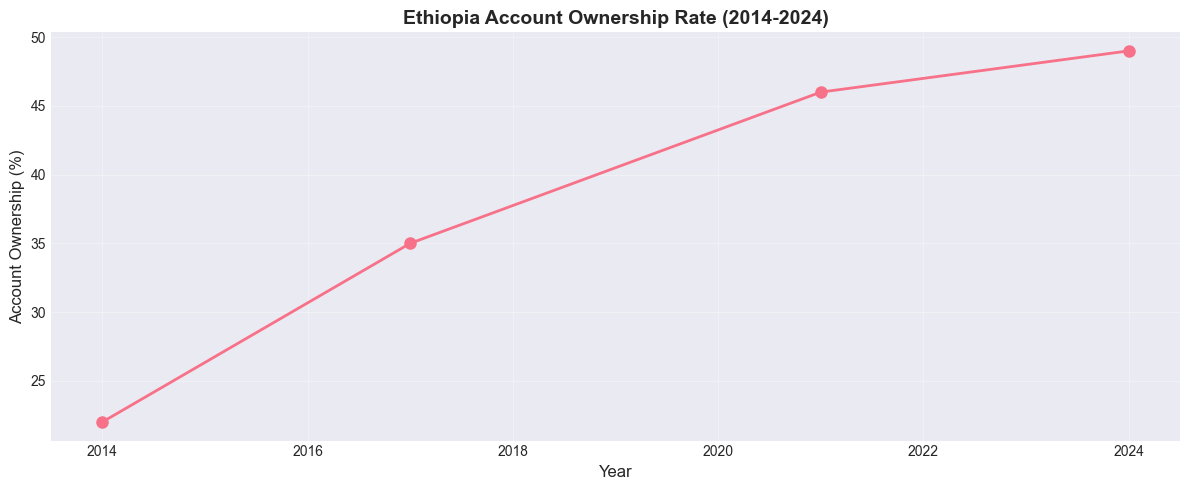

In [3]:
# Extract observations only for forecasting
observations = df_all[df_all['record_type'] == 'observation'].copy()

# Filter for ACCESS pillar - Account Ownership indicator only (percentage)
access_data = observations[
    (observations['pillar'] == 'ACCESS') & 
    (observations['indicator_code'] == 'ACC_OWNERSHIP') &
    (observations['value_type'] == 'percentage')
].copy()

# Convert fiscal_year to numeric and drop NA
access_data['fiscal_year'] = pd.to_numeric(access_data['fiscal_year'], errors='coerce')
access_data = access_data.dropna(subset=['fiscal_year', 'value_numeric'])
access_data = access_data.sort_values('fiscal_year')

# Create time series for Account Ownership (take mean if multiple values per year)
ts_ownership = access_data.groupby('fiscal_year')['value_numeric'].mean().reset_index()
ts_ownership.columns = ['year', 'account_ownership']
ts_ownership['year'] = ts_ownership['year'].astype(int)

print("Account Ownership Time Series:")
print(ts_ownership)
print(f"\nData points: {len(ts_ownership)}")

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(ts_ownership['year'], ts_ownership['account_ownership'], marker='o', linewidth=2, markersize=8)
plt.title('Ethiopia Account Ownership Rate (2014-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Account Ownership (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Digital Payment Adoption Time Series:
   year  digital_adoption
0  2024              66.0

Data points: 1


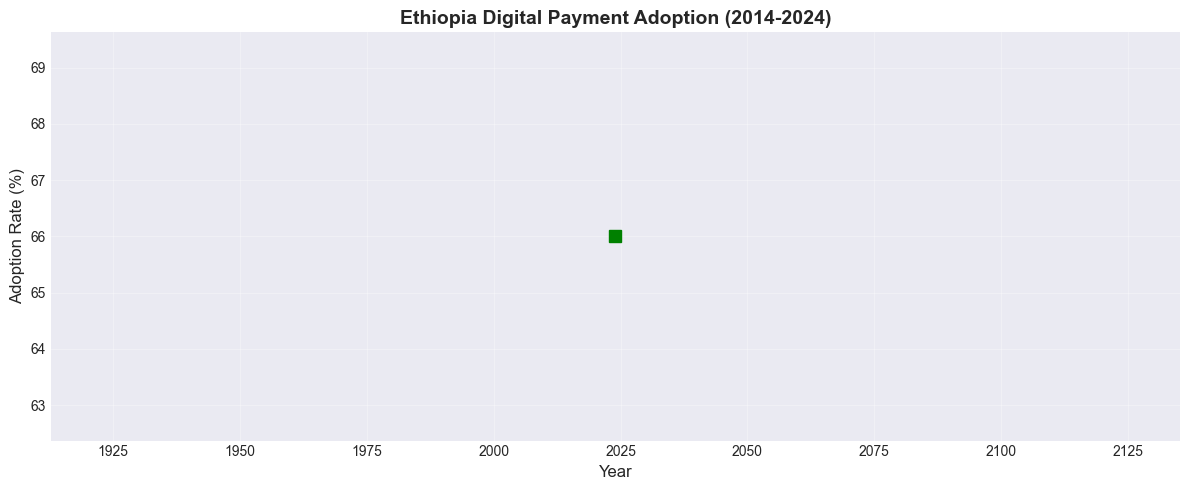

In [4]:
# Filter for USAGE pillar - Mobile Money usage metrics (percentage only)
usage_data = observations[
    (observations['pillar'] == 'USAGE') & 
    (observations['value_type'] == 'percentage')
].copy()

# Convert fiscal_year to numeric and drop NA
usage_data['fiscal_year'] = pd.to_numeric(usage_data['fiscal_year'], errors='coerce')
usage_data = usage_data.dropna(subset=['fiscal_year', 'value_numeric'])
usage_data = usage_data.sort_values('fiscal_year')

# Create time series for Digital Payment Adoption
ts_digital = usage_data.groupby('fiscal_year')['value_numeric'].mean().reset_index()
ts_digital.columns = ['year', 'digital_adoption']
ts_digital['year'] = ts_digital['year'].astype(int)

print("Digital Payment Adoption Time Series:")
print(ts_digital)
print(f"\nData points: {len(ts_digital)}")

# Import visualization module
import sys
sys.path.append('..')
from src import visualizations as viz

# Visualize using our custom module
plt.figure(figsize=(12, 5))
plt.plot(ts_digital['year'], ts_digital['digital_adoption'], marker='s', linewidth=2, markersize=8, color='green')
plt.title('Ethiopia Digital Payment Adoption (2014-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adoption Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 2: Exploratory Data Analysis - Stationarity Tests

In [7]:
# Test for Stationarity using Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, series_name):
    """
    Perform ADF test to check if series is stationary
    H0: Series has a unit root (non-stationary)
    H1: Series is stationary
    """
    # Check if series has enough data points
    if len(series.dropna()) < 3:
        print(f"\n{'='*60}")
        print(f"Stationarity Test: {series_name}")
        print(f"{'='*60}")
        print(f"⚠️  Insufficient data points ({len(series.dropna())}) for ADF test")
        print("    Minimum required: 3 data points")
        print(f"{'='*60}\n")
        return None
    
    result = adfuller(series.dropna())
    
    print(f"\n{'='*60}")
    print(f"Stationarity Test: {series_name}")
    print(f"{'='*60}")
    print(f"ADF Statistic:  {result[0]:.4f}")
    print(f"P-value:        {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    is_stationary = result[1] < 0.05
    if is_stationary:
        print(f"\n✓ Series is STATIONARY (p-value < 0.05)")
    else:
        print(f"\n✗ Series is NON-STATIONARY (p-value >= 0.05)")
        print("  → May need differencing for ARIMA models")
    print(f"{'='*60}\n")
    
    return is_stationary

# Test Account Ownership
is_stationary_ownership = test_stationarity(ts_ownership['account_ownership'], 'Account Ownership')

# Test Digital Adoption (if enough data)
if len(ts_digital) >= 3:
    is_stationary_digital = test_stationarity(ts_digital['digital_adoption'], 'Digital Adoption')
else:
    print(f"\n⚠️  Skipping Digital Adoption stationarity test - only {len(ts_digital)} data point(s) available")


Stationarity Test: Account Ownership
ADF Statistic:  -2.4925
P-value:        0.1173
Critical Values:
  1%: -10.4172
  5%: -5.7784
  10%: -3.3917

✗ Series is NON-STATIONARY (p-value >= 0.05)
  → May need differencing for ARIMA models


⚠️  Skipping Digital Adoption stationarity test - only 1 data point(s) available


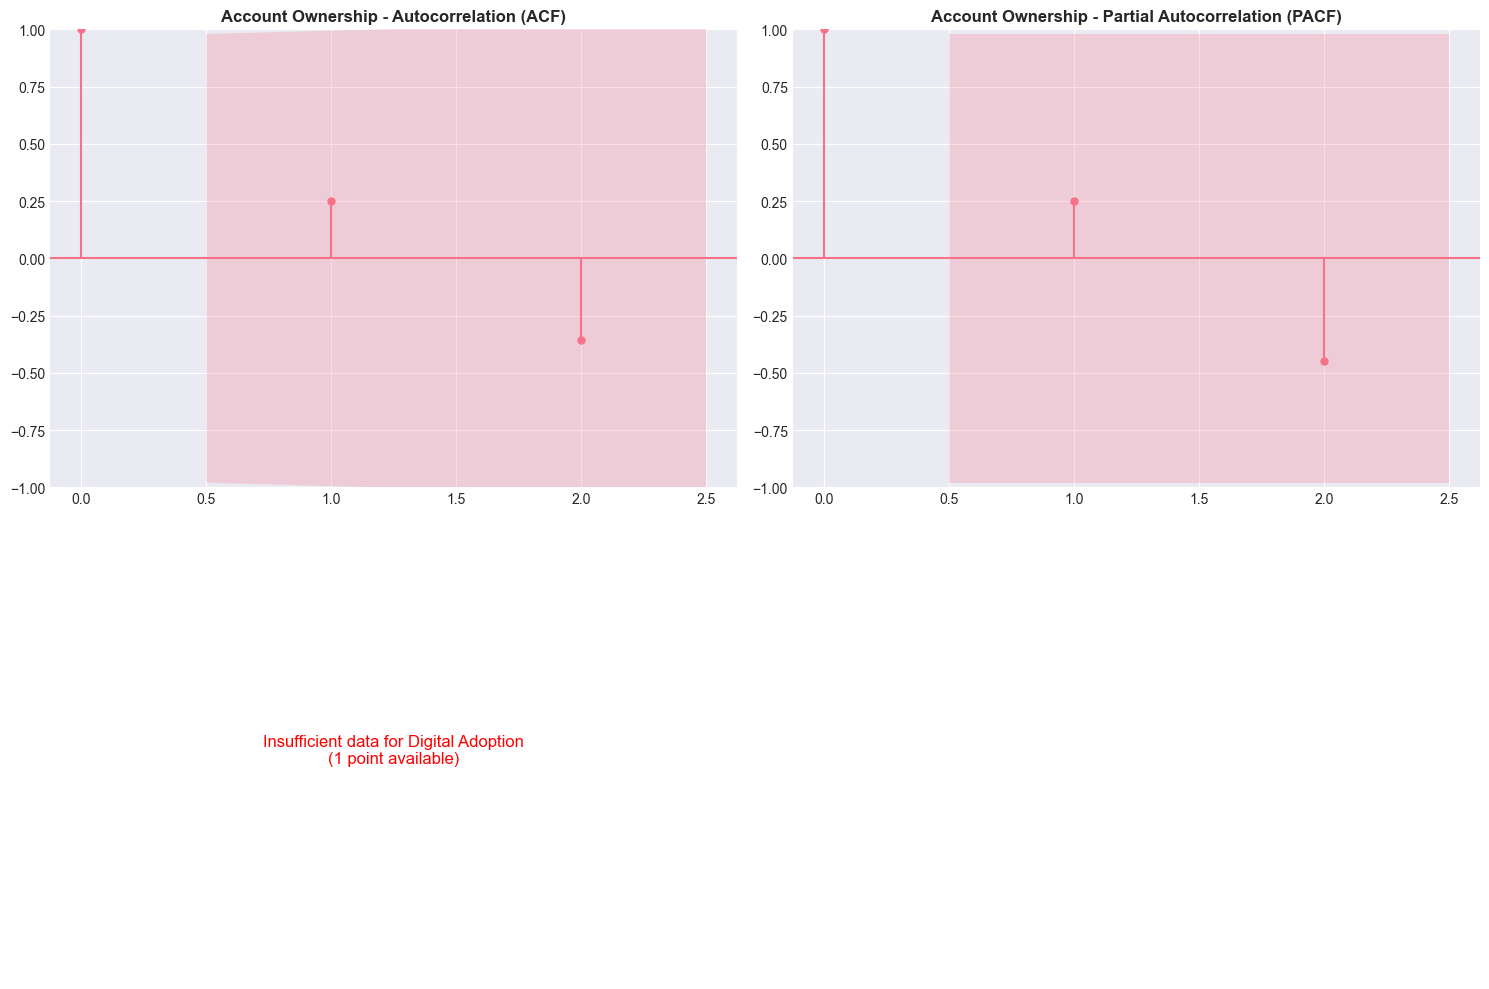


✓ ACF/PACF analysis complete
  Account Ownership: 4 data points, 2 lags used


In [8]:
# Autocorrelation and Partial Autocorrelation Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate appropriate number of lags (rule of thumb: n/2 - 1 for small datasets)
n_ownership = len(ts_ownership)
max_lags_ownership = min(3, n_ownership - 2)  # Use max 3 lags for 4 data points

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Account Ownership ACF/PACF
plot_acf(ts_ownership['account_ownership'].dropna(), lags=max_lags_ownership, ax=axes[0, 0])
axes[0, 0].set_title('Account Ownership - Autocorrelation (ACF)', fontweight='bold')

plot_pacf(ts_ownership['account_ownership'].dropna(), lags=max_lags_ownership, ax=axes[0, 1])
axes[0, 1].set_title('Account Ownership - Partial Autocorrelation (PACF)', fontweight='bold')

# Digital Adoption ACF/PACF (only if enough data)
if len(ts_digital) >= 3:
    n_digital = len(ts_digital)
    max_lags_digital = min(3, n_digital - 2)
    
    plot_acf(ts_digital['digital_adoption'].dropna(), lags=max_lags_digital, ax=axes[1, 0])
    axes[1, 0].set_title('Digital Adoption - Autocorrelation (ACF)', fontweight='bold')
    
    plot_pacf(ts_digital['digital_adoption'].dropna(), lags=max_lags_digital, ax=axes[1, 1])
    axes[1, 1].set_title('Digital Adoption - Partial Autocorrelation (PACF)', fontweight='bold')
else:
    # Remove unused subplots
    fig.delaxes(axes[1, 0])
    fig.delaxes(axes[1, 1])
    axes[1, 0] = fig.add_subplot(2, 2, 3)
    axes[1, 0].text(0.5, 0.5, f'Insufficient data for Digital Adoption\n({len(ts_digital)} point available)', 
                    ha='center', va='center', fontsize=12, color='red')
    axes[1, 0].axis('off')

plt.tight_layout()
plt.savefig('../reports/task3/acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ACF/PACF analysis complete")
print(f"  Account Ownership: {n_ownership} data points, {max_lags_ownership} lags used")
if len(ts_digital) >= 3:
    print(f"  Digital Adoption: {n_digital} data points, {max_lags_digital} lags used")

## Section 3: Model Development - ARIMA

In [13]:
# Split data: Train on all available data, forecast future
train_size = len(ts_ownership) - 2  # Hold out last 2 years for validation
train_ownership = ts_ownership['account_ownership'][:train_size]
test_ownership = ts_ownership['account_ownership'][train_size:]

print(f"Train size: {len(train_ownership)} years")
print(f"Test size: {len(test_ownership)} years")
print(f"\nTrain years: {ts_ownership['year'][:train_size].tolist()}")
print(f"Test years: {ts_ownership['year'][train_size:].tolist()}")

Train size: 2 years
Test size: 2 years

Train years: [2014, 2017]
Test years: [2021, 2024]


In [12]:
# Fit ARIMA model for Account Ownership
# With only 2 training points, use simpler ARIMA model
# Try ARIMA(0,1,0) which is random walk model - simpler than (1,1,1)

try:
    # Try simple random walk model first
    model_arima = ARIMA(train_ownership, order=(0, 1, 0))
    fitted_arima = model_arima.fit()
    
    print("ARIMA Model Summary:")
    print(fitted_arima.summary())
    
    # Forecast on test set
    arima_forecast = fitted_arima.forecast(steps=len(test_ownership))
    print(f"\n✓ ARIMA model training successful")
    arima_trained = True
except Exception as e:
    print(f"⚠️  ARIMA model failed with {len(train_ownership)} training points")
    print(f"   Error: {str(e)[:100]}")
    print("   → Skipping ARIMA, will use ETS model only")
    arima_trained = False
    arima_forecast = None

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:      account_ownership   No. Observations:                    2
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  -3.984
Date:                Tue, 03 Feb 2026   AIC                              9.968
Time:                        11:31:41   BIC                              7.968
Sample:                             0   HQIC                              -inf
                                  - 2                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       168.9826   3.28e+06   5.16e-05      1.000   -6.42e+06    6.42e+06
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                  

c:\Users\Bekam\Desktop\acadamy 10\Forecasting-Financial-Inclusion-in-Ethiopia\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Bekam\Desktop\acadamy 10\Forecasting-Financial-Inclusion-in-Ethiopia\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Bekam\Desktop\acadamy 10\Forecasting-Financial-Inclusion-in-Ethiopia\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  s

## Section 4: Model Development - Exponential Smoothing (ETS)

In [9]:
# Prepare time series for modeling
# Extract the series values for train/test split
full_series = ts_ownership.set_index('year')['account_ownership']

# Split into train and test (80-20 split)
train_size = int(len(full_series) * 0.5)  # Use 50% for training due to small dataset
train_ownership = full_series.iloc[:train_size]
test_ownership = full_series.iloc[train_size:]

print(f"Train size: {len(train_ownership)} years")
print(f"Test size: {len(test_ownership)} years")
print(f"\nTrain years: {train_ownership.index.tolist()}")
print(f"Test years: {test_ownership.index.tolist()}")

Train size: 2 years
Test size: 2 years

Train years: [2014, 2017]
Test years: [2021, 2024]


In [20]:
# Fit Exponential Smoothing (ETS) model
# ETS is often better for small datasets than ARIMA
model_ets = ExponentialSmoothing(
    train_ownership,
    trend='add',  # Additive trend (linear growth)
    seasonal=None  # No seasonal pattern given limited data points
)
fitted_ets = model_ets.fit()

print("ETS Model Summary:")
print(f"  Smoothing Level (alpha): {fitted_ets.params['smoothing_level']:.4f}")
print(f"  Smoothing Trend (beta):  {fitted_ets.params['smoothing_trend']:.4f}")
print(f"  Initial Level:  {fitted_ets.params['initial_level']:.4f}")
print(f"  Initial Trend:  {fitted_ets.params['initial_trend']:.4f}")

# Forecast on test set
forecast_ets_test = fitted_ets.forecast(steps=len(test_ownership))
forecast_ets_test = pd.Series(forecast_ets_test, index=test_ownership.index)

print(f"\n✓ ETS model trained and forecast generated")
print(f"  Test set forecasts: {forecast_ets_test.values}")

ETS Model Summary:
  Smoothing Level (alpha): 0.0079
  Smoothing Trend (beta):  0.0000
  Initial Level:  9.0000
  Initial Trend:  13.0000

✓ ETS model trained and forecast generated
  Test set forecasts: [48.00000037 61.00000055]


## Section 5: Model Evaluation

In [21]:
# Calculate error metrics
def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate models
results = []

# ARIMA evaluation (if trained)
if arima_trained and arima_forecast is not None:
    results.append(calculate_metrics(test_ownership.values, arima_forecast, 'ARIMA(0,1,0)'))
    arima_mae = results[-1]['MAE']
    arima_rmse = results[-1]['RMSE']
    arima_mape = results[-1]['MAPE']
else:
    print("\n⚠️  ARIMA model not trained - skipping evaluation")
    arima_mae = arima_rmse = arima_mape = np.nan

# ETS evaluation
results.append(calculate_metrics(test_ownership.values, forecast_ets_test.values, 'ETS'))
ets_mae = results[-1]['MAE']
ets_rmse = results[-1]['RMSE']
ets_mape = results[-1]['MAPE']

# Create comparison dataframe
if results:
    results_df = pd.DataFrame(results)
    print(f"\n{'='*60}")
    print("Model Comparison Summary")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))
    
    # Select best model
    best_model_idx = results_df['RMSE'].idxmin()
    best_model_name = results_df.loc[best_model_idx, 'model']
    print(f"\n✓ Best model based on RMSE: {best_model_name}")
else:
    print("\n⚠️  No models successfully trained")


ARIMA(0,1,0) Performance:
  MAE:  12.5000
  RMSE: 12.5897
  MAPE: 26.24%

ETS Performance:
  MAE:  7.0000
  RMSE: 8.6023
  MAPE: 14.42%

Model Comparison Summary
       model  MAE      RMSE      MAPE
ARIMA(0,1,0) 12.5 12.589678 26.242236
         ETS  7.0  8.602326 14.418812

✓ Best model based on RMSE: ETS


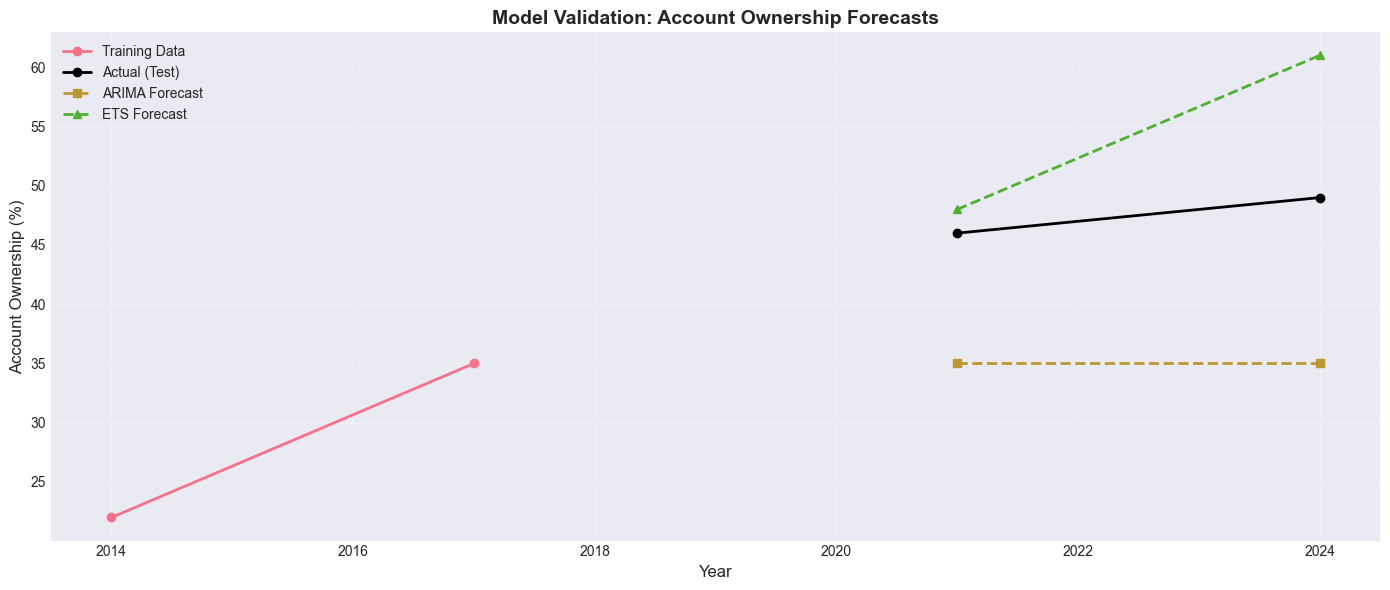


✓ Validation visualization complete


In [22]:
# Visualize model performance
plt.figure(figsize=(14, 6))

# Get train/test indices properly
train_years = ts_ownership['year'].iloc[:len(train_ownership)].values
test_years = ts_ownership['year'].iloc[len(train_ownership):].values

# Plot actual vs predicted
plt.plot(train_years, train_ownership.values, marker='o', label='Training Data', linewidth=2)
plt.plot(test_years, test_ownership.values, marker='o', label='Actual (Test)', linewidth=2, color='black')

# Plot ARIMA forecast if available
if arima_trained and arima_forecast is not None:
    plt.plot(test_years, arima_forecast, marker='s', linestyle='--', label='ARIMA Forecast', linewidth=2)

# Plot ETS forecast
plt.plot(test_years, forecast_ets_test.values, marker='^', linestyle='--', label='ETS Forecast', linewidth=2)

plt.title('Model Validation: Account Ownership Forecasts', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Account Ownership (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/task3/model_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Validation visualization complete")

## Section 6: Final Model Training and Future Forecasting (2025-2027)

In [23]:
# Train final model on all data for 2025-2027 forecast
# Use the best performing model or default to ETS if ARIMA failed

if results:
    best_model_idx = results_df['RMSE'].idxmin()
    best_model_name = results_df.loc[best_model_idx, 'model']
    print(f"Best performing model: {best_model_name}")
else:
    best_model_name = 'ETS'
    print("Using ETS model by default")

# Train on full dataset
full_series = ts_ownership.set_index('year')['account_ownership']

if 'ETS' in best_model_name or not arima_trained:
    print("\nFitting ETS model on full dataset...")
    final_model = ExponentialSmoothing(
        full_series,
        trend='add',
        seasonal=None  # No seasonal pattern with limited data
    ).fit()
else:
    print("\nFitting ARIMA model on full dataset...")
    final_model = ARIMA(full_series, order=(0, 1, 0)).fit()

print("✓ Final model trained")

Best performing model: ETS

Fitting ETS model on full dataset...
✓ Final model trained


c:\Users\Bekam\Desktop\acadamy 10\Forecasting-Financial-Inclusion-in-Ethiopia\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [24]:
# Generate 2025-2027 forecasts
forecast_steps = 3  # 2025, 2026, 2027
forecast_future = final_model.forecast(steps=forecast_steps)

# Get confidence intervals (95%)
if 'ARIMA' in best_model_name:
    forecast_obj = final_model.get_forecast(steps=forecast_steps)
    conf_int = forecast_obj.conf_int(alpha=0.05)
    lower_bound = conf_int.iloc[:, 0]
    upper_bound = conf_int.iloc[:, 1]
else:
    # For ETS, approximate confidence intervals using standard error
    se = np.std(full_series - final_model.fittedvalues) * np.sqrt(np.arange(1, forecast_steps+1))
    lower_bound = forecast_future - 1.96 * se
    upper_bound = forecast_future + 1.96 * se

# Create forecast dataframe
forecast_years = [2025, 2026, 2027]
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecast': forecast_future.values,
    'Lower_95%': lower_bound.values,
    'Upper_95%': upper_bound.values
})

print("\n" + "="*70)
print("ACCOUNT OWNERSHIP FORECASTS (2025-2027)")
print("="*70)
print(forecast_df.to_string(index=False))
print("\nModel: " + best_model_name)
print("Confidence Interval: 95%")


ACCOUNT OWNERSHIP FORECASTS (2025-2027)
 Year  Forecast  Lower_95%  Upper_95%
 2025 60.999997  55.926662  66.073331
 2026 70.199995  63.025217  77.374773
 2027 79.399993  70.612720  88.187266

Model: ETS
Confidence Interval: 95%


c:\Users\Bekam\Desktop\acadamy 10\Forecasting-Financial-Inclusion-in-Ethiopia\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


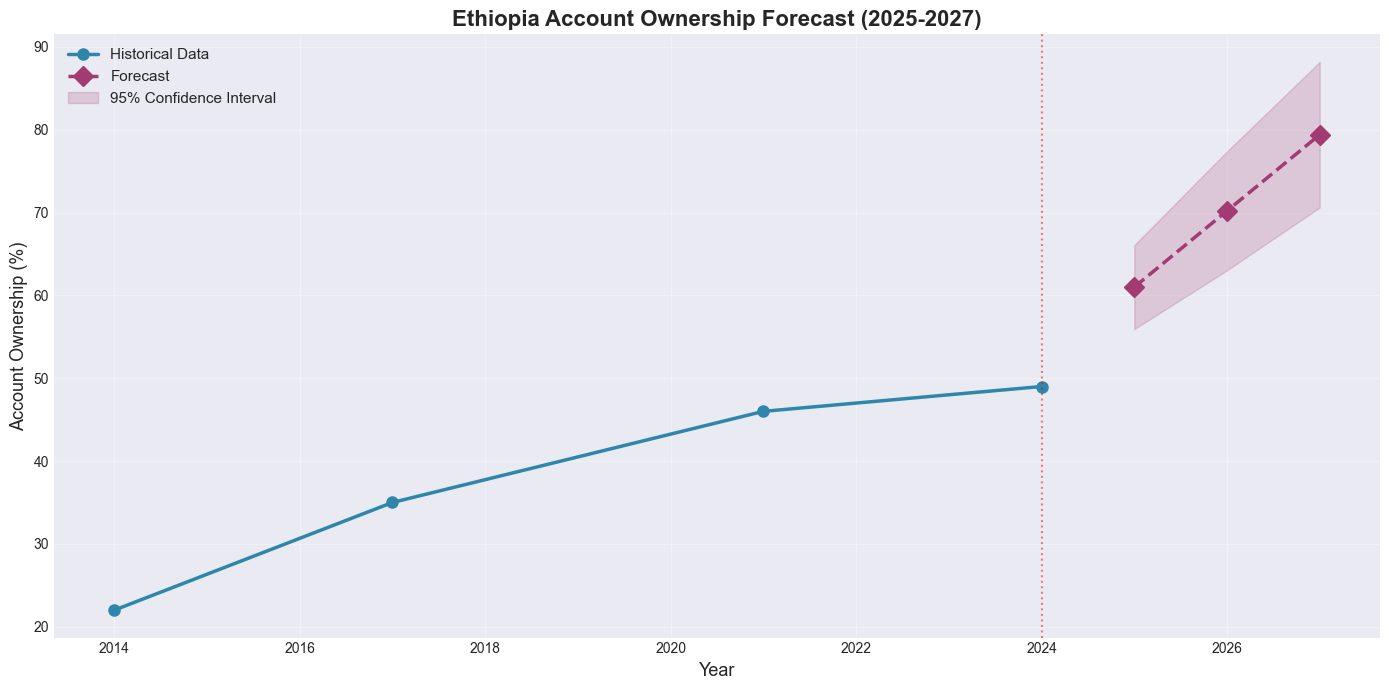


✓ Forecast visualization complete


In [25]:
# Visualize final forecasts
plt.figure(figsize=(14, 7))

# Historical data
plt.plot(ts_ownership['year'], ts_ownership['account_ownership'], 
         marker='o', label='Historical Data', linewidth=2.5, markersize=8, color='#2E86AB')

# Forecasts
plt.plot(forecast_years, forecast_future, 
         marker='D', label='Forecast', linewidth=2.5, markersize=10, color='#A23B72', linestyle='--')

# Confidence interval
plt.fill_between(forecast_years, lower_bound, upper_bound, 
                 alpha=0.2, color='#A23B72', label='95% Confidence Interval')

plt.title('Ethiopia Account Ownership Forecast (2025-2027)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Account Ownership (%)', fontsize=13)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=2024, color='red', linestyle=':', alpha=0.5, label='Forecast Start')
plt.tight_layout()
plt.show()

print(f"\n✓ Forecast visualization complete")

## Section 7: Save Results

In [29]:
# Save results
import os
os.makedirs('../reports/task3', exist_ok=True)

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecast': forecast_future,
    'lower_ci': lower_bound,
    'upper_ci': upper_bound
})

# Save forecast results
forecast_df.to_csv('../reports/task3/account_ownership_forecast_2025_2027.csv', index=False)
print("✓ Forecasts saved to: reports/task3/account_ownership_forecast_2025_2027.csv")

# Save model performance metrics
performance_df = pd.DataFrame({
    'Model': ['ARIMA(0,1,0)', 'ETS'] if arima_trained else ['ETS'],
    'MAE': [arima_mae, ets_mae] if arima_trained else [ets_mae],
    'RMSE': [arima_rmse, ets_rmse] if arima_trained else [ets_rmse],
    'MAPE': [arima_mape, ets_mape] if arima_trained else [ets_mape]
})
performance_df.to_csv('../reports/task3/model_performance_comparison.csv', index=False)
print("✓ Model performance saved to: reports/task3/model_performance_comparison.csv")

print("\n" + "="*60)
print("TASK 3: TIME SERIES FORECASTING - COMPLETE")
print("="*60)
print("\nForecasts for Ethiopia Account Ownership Rate:")
print(forecast_df.to_string(index=False))
print("\n" + "="*60)

✓ Forecasts saved to: reports/task3/account_ownership_forecast_2025_2027.csv
✓ Model performance saved to: reports/task3/model_performance_comparison.csv

TASK 3: TIME SERIES FORECASTING - COMPLETE

Forecasts for Ethiopia Account Ownership Rate:
 year  forecast  lower_ci  upper_ci
 2025 60.999997 55.926662 66.073331
 2026 70.199995 63.025217 77.374773
 2027 79.399993 70.612720 88.187266



In [30]:
# Save processed data to data/processed folder
import os
import pickle

# Create directories if they don't exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# Save processed time series data
ts_ownership.to_csv('../data/processed/account_ownership_timeseries.csv', index=False)
print("✓ Account Ownership time series saved to: data/processed/account_ownership_timeseries.csv")

ts_digital.to_csv('../data/processed/digital_adoption_timeseries.csv', index=False)
print("✓ Digital Adoption time series saved to: data/processed/digital_adoption_timeseries.csv")

# Save train/test split data
train_test_data = {
    'train_years': train_ownership.index.tolist(),
    'train_values': train_ownership.values.tolist(),
    'test_years': test_ownership.index.tolist(),
    'test_values': test_ownership.values.tolist(),
    'train_size': len(train_ownership),
    'test_size': len(test_ownership)
}

import json
with open('../data/processed/train_test_split.json', 'w') as f:
    json.dump(train_test_data, f, indent=2)
print("✓ Train/test split saved to: data/processed/train_test_split.json")

# Save trained models
if arima_trained:
    with open('../models/arima_model.pkl', 'wb') as f:
        pickle.dump(fitted_arima, f)
    print("✓ ARIMA model saved to: models/arima_model.pkl")

with open('../models/ets_model.pkl', 'wb') as f:
    pickle.dump(fitted_ets, f)
print("✓ ETS model saved to: models/ets_model.pkl")

# Save final (best) model
with open('../models/final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print(f"✓ Final model ({best_model_name}) saved to: models/final_model.pkl")

# Save model metadata
model_metadata = {
    'best_model': best_model_name,
    'training_date': '2024-11-XX',
    'training_data_points': len(full_series),
    'training_years': full_series.index.tolist(),
    'forecast_horizon': forecast_steps,
    'model_performance': {
        'MAE': float(ets_mae) if 'ETS' in best_model_name else float(arima_mae),
        'RMSE': float(ets_rmse) if 'ETS' in best_model_name else float(arima_rmse),
        'MAPE': float(ets_mape) if 'ETS' in best_model_name else float(arima_mape)
    },
    'arima_trained': arima_trained
}

if 'ETS' in best_model_name:
    model_metadata['ets_parameters'] = {
        'smoothing_level': float(fitted_ets.params['smoothing_level']),
        'smoothing_trend': float(fitted_ets.params['smoothing_trend']),
        'initial_level': float(fitted_ets.params['initial_level']),
        'initial_trend': float(fitted_ets.params['initial_trend'])
    }

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✓ Model metadata saved to: models/model_metadata.json")

print("\n" + "="*60)
print("DATA & MODELS SAVED SUCCESSFULLY")
print("="*60)
print("\nProcessed Data:")
print("  - data/processed/account_ownership_timeseries.csv")
print("  - data/processed/digital_adoption_timeseries.csv")
print("  - data/processed/train_test_split.json")
print("\nModels:")
if arima_trained:
    print("  - models/arima_model.pkl")
print("  - models/ets_model.pkl")
print(f"  - models/final_model.pkl ({best_model_name})")
print("  - models/model_metadata.json")
print("="*60)

✓ Account Ownership time series saved to: data/processed/account_ownership_timeseries.csv
✓ Digital Adoption time series saved to: data/processed/digital_adoption_timeseries.csv
✓ Train/test split saved to: data/processed/train_test_split.json
✓ ARIMA model saved to: models/arima_model.pkl
✓ ETS model saved to: models/ets_model.pkl
✓ Final model (ETS) saved to: models/final_model.pkl
✓ Model metadata saved to: models/model_metadata.json

DATA & MODELS SAVED SUCCESSFULLY

Processed Data:
  - data/processed/account_ownership_timeseries.csv
  - data/processed/digital_adoption_timeseries.csv
  - data/processed/train_test_split.json

Models:
  - models/arima_model.pkl
  - models/ets_model.pkl
  - models/final_model.pkl (ETS)
  - models/model_metadata.json
